In [44]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil

## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

In [45]:
image_path = "./images"

In [46]:
def save_image(image):
        with open(f'{self.image_path}/img_{count}.{img_type}', 'wb') as f:
            f.write(image)

In [47]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        save_image(image)
        count += 1
        
        # A time.sleep(x) is recommended to avoid latency errors

We can now call this function and store the images locally

```python
fetch_images(k=10_000, folder_name='images')
```

## Validating image
We should validate wether the image exists

In [48]:
image = io.imread(f'{image_path}/img_0.png')
IMAGE_TYPE = type(image)

In [49]:
def read_image(folder_name:str, idx:int) -> IMAGE_TYPE:
    return io.imread(f'{folder_name}/img_{idx}.png')

In [50]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = read_image(image_path, 0)
        return True
    except:
        print(f'Image "img_0.png" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [51]:
def show_batch(batch):
    images = np.random.randint(low=0, high=len(batch), size=16) # get random indices
    fig = plt.figure(figsize= (4, 4)) 
    fig, axs = plt.subplots(4,4, sharex=True, sharey=True)
    cnt = 0 
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

In [52]:
def img_attr(batch):
    print(f'Images are {batch[0].shape[0]} by {batch[0].shape[1]} with {batch[0].shape[2]} channels')

Retreive all images from dataset

In [53]:
def read_collection(folder_name:str):
    return imread_collection(f'{folder_name}/*.png')

In [54]:
collection = read_collection(image_path)

In [56]:
len(collection)

10000

<Figure size 288x288 with 0 Axes>

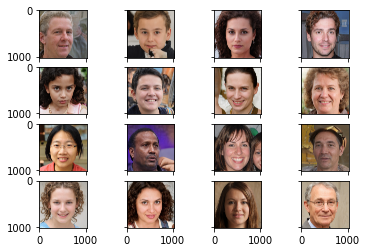

In [57]:
show_batch(collection)

In [59]:
collection[0].shape

(1024, 1024, 3)

In [60]:
img_attr(collection)

Images are 1024 by 1024 with 3 channels


### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels

In [61]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [62]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

We first import libraries to be used

In [63]:
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation, Conv2D, BatchNormalization, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
import time

In [64]:
z_dim = 512 # 512 is a good default

We implement the schematics for $G(z)$ to generate $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks), [Karras, Aila. (2018). Progressive Growing of GANs for Improved Quality Stability, and Variation.](https://arxiv.org/pdf/1710.10196.pdf)

#### Generator 

In [65]:
from keras.utils.vis_utils import plot_model

In [66]:
def model_to_png(model, file_name:str):
    plot_model(model, to_file=f'{file_name}.png', show_shapes=True)

In [67]:
def create_generator(z):
    model = Sequential()
    
    # Input Latent vector
    model.add(Dense(512, input_dim=z))
    model.add(Reshape((1, 1, 512)))
    
    # Conv 1.0 (4x4) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=4, padding='valid'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 2.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 3.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 4.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 5.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 6.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(256, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(256, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 7.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(128, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 8.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 9.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(32, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 10.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(16, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2DTranspose(3, kernel_size=1, padding='valid')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(Activation('tanh'))
    return model

We can test our generator's functionality

In [68]:
def test_gen(z):
    gen = create_generator(z)
    noise = tf.random.normal([1, 512],)
    img = gen(noise, training=False)
    img = tf.reshape(img, shape=(img.shape[1], img.shape[2], img.shape[3]))
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


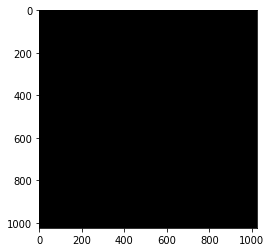

In [69]:
test_gen(z=z_dim)

#### Discriminator

In [70]:
def create_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(3, kernel_size=1, padding='same', input_shape=img_shape))
    model.add(Conv2D(3, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    
    # Conv 2.0
    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 3.0
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 4.0
    model.add(Conv2D(256, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(256, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 5.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 6.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 7.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 8.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Final 
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding='valid', input_shape=img_shape))
    
    # Finalized
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

#### Set up (S) - 1.1 Create
We begin by initializing the discriminator and generator

In [71]:
generator = create_generator(z=z_dim)
discriminator = create_discriminator(img_shape=image_shape)

#### S - 1.2 Compile 
We know compile both models. <br>
NOTE: _Implement OS exisitng model loading_

##### Generator Compile

In [72]:
generator.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

##### Discriminator Compile

In [73]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#### S - 1.3 Disable Discriminator Training

In [74]:
discriminator.trainable = False

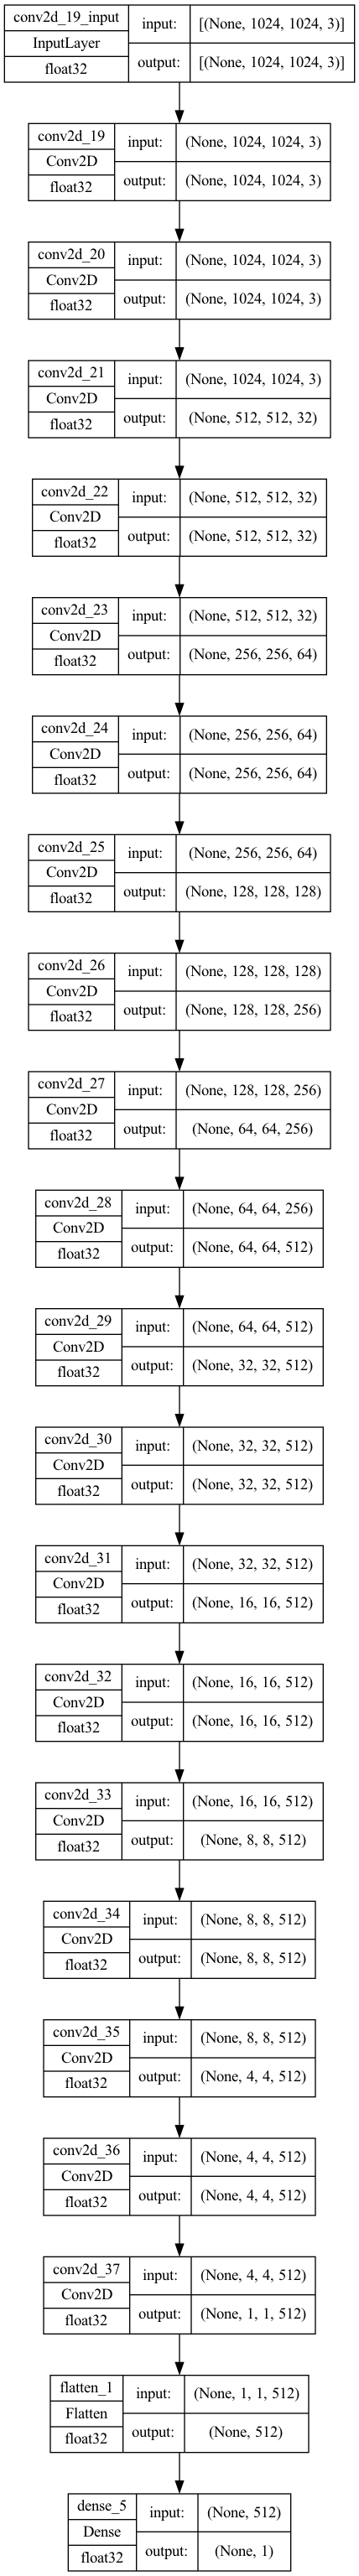

In [75]:
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

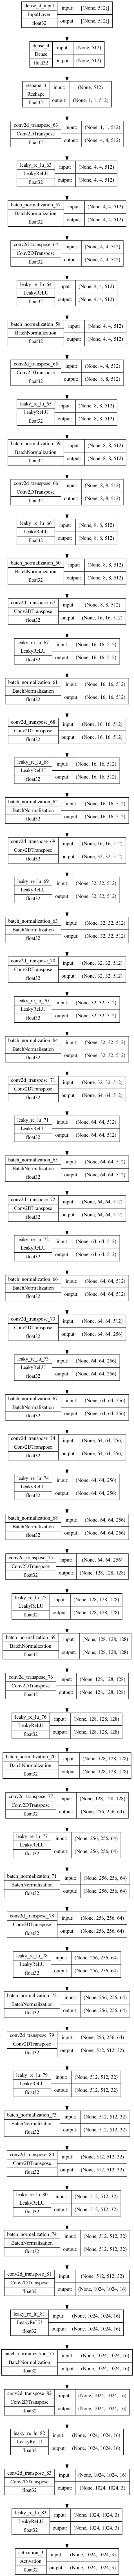

In [77]:
plot_model(generator, to_file='generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [79]:
def GAN(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [80]:
gan = GAN(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

#### TESTING DISCRIMINATOR
---
```python
noise = tf.random.normal([1, 512],)
img = generator(noise, training=False)
disc_output = discriminator(img, training=False)
print("Discriminator output on fake images:", disc_output.numpy())
real_image = collection[0]
disc_2_output = discriminator(np.expand_dims(real_image, axis=0), training=False)
```
---

#### S - 1.4 Training Iterations

#### S - 1.4.1 Params

In [106]:
iterations = 30
batch_size = 32
sample_interval = 2

In [107]:
def time_stamp(msg:str, time):
    print(f'{msg} - {time}')

In [108]:
def get_time():
    return time.ctime(time.time())

In [109]:
def train_gan(iteraions:int, batch_size:int, sample_interval:int):
    collection = read_collection(image_path)
    image_count = 0
    
    # Collect batch
    time_stamp("Collecting images ...", get_time())
    real_image_batch = np.array(collection[:sample_interval]) # get batch
    real_image_batch = np.array(collection[:sample_interval]) / 127.5 - 1.0 # rescale [-1,1]
    time_stamp("Finishing ...", get_time())
    
    
    # Labels 
    time_stamp("Generating labels ...", get_time())
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    time_stamp("Finishing ...", get_time())
    
    # Training
    for iteration in range(iterations):
        time_stamp(f'Iteration {iteration} of {iterations}', get_time())
        
        # Random batch of real images
        batch_of_real_indecies = np.random.randint(0, real_image_batch.shape[0], batch_size)
        batch_of_real_imgs = real_image_batch[batch_of_real_indecies]
        
        # Random batch of fake images
        z_fake = np.random.normal(0, 1, (batch_size, 512))
        generated_images = generator.predict(z_fake)
        
        # Train Discriminator -> [Loss, Accuracy]
        time_stamp("Training discriminator ...", get_time())
        discriminator_real_loss = discriminator.train_on_batch(batch_of_real_imgs, real_labels)       
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
        
        # Get Discriminator loss and accuracy
        discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
        
        # Train Generator
        time_stamp("Training generator ...", get_time())
        z_fake = np.random.normal(0, 1, (batch_size, 512))
        generated_images = generator.predict(z_fake)
        
        
        # Get Generator loss and accuracy
        gan_loss = gan.train_on_batch(z_fake, real_labels)
        time_stamp(f'Epoch time {iteration}', get_time())
        
        # Progress output
        if (iteration + 1) % sample_interval == 0:
            print("%d [D loss: %f, acc.:%.2f%%] [G loss: %f]" % (iteration + 1, discriminator_loss, 100.0* accuracy, gan_loss))
            
            # Generate random images
            z_generated = np.random.randint(0, 1, (3*3, z_dim))
            generate_images = generator.predict(z_generated)
            generate_images = 0.5 * generate_images + 0.5
            
            # Plot
            fig = plt.figure(figsize= (3, 3)) 
            fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
            cnt = 0 
            for i in range(3):
                for j in range(3):
                    axs[i, j].imshow(generate_images[cnt]) # get image from batch at index 'i'
                    cnt += 1
            plt.savefig(f'iteration{image_count}-gan.png')
            image_count += 1
            plt.show()

#### Training the network
```python
train_gan(iterations, batch_size, sample_interval)
```

Finishing ... - Fri Feb 24 18:51:19 2023
Generating labels ... - Fri Feb 24 18:51:19 2023
Finishing ... - Fri Feb 24 18:51:19 2023
Iteration 0 of 30 - Fri Feb 24 18:51:19 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 18:51:39 2023
Training generator ... - Fri Feb 24 18:52:22 2023
1/1 [==============================] - 19s 19s/step
Epoch time 0 - Fri Feb 24 18:54:22 2023
Iteration 1 of 30 - Fri Feb 24 18:54:22 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 18:54:41 2023
Training generator ... - Fri Feb 24 18:55:20 2023
1/1 [==============================] - 19s 19s/step
Epoch time 1 - Fri Feb 24 18:57:18 2023
2 [D loss: 0.000000, acc.:100.00%] [G loss: 0.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

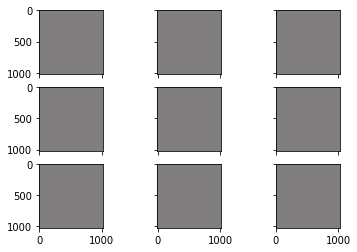

Iteration 2 of 30 - Fri Feb 24 18:57:26 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 18:57:45 2023
Training generator ... - Fri Feb 24 18:58:24 2023
1/1 [==============================] - 19s 19s/step
Epoch time 2 - Fri Feb 24 19:00:25 2023
Iteration 3 of 30 - Fri Feb 24 19:00:25 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 19:00:45 2023
Training generator ... - Fri Feb 24 19:01:24 2023
1/1 [==============================] - 19s 19s/step
Epoch time 3 - Fri Feb 24 19:03:27 2023
4 [D loss: 0.000000, acc.:100.00%] [G loss: 0.000000]
1/1 [==============================] - 6s 6s/step


<Figure size 216x216 with 0 Axes>

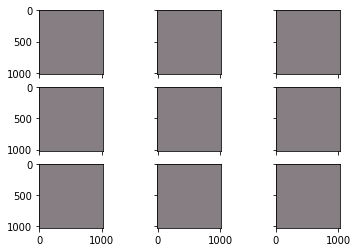

Iteration 4 of 30 - Fri Feb 24 19:03:36 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 19:03:56 2023
Training generator ... - Fri Feb 24 19:04:36 2023
1/1 [==============================] - 19s 19s/step
Epoch time 4 - Fri Feb 24 19:06:35 2023
Iteration 5 of 30 - Fri Feb 24 19:06:35 2023
1/1 [==============================] - 20s 20s/step
Training discriminator ... - Fri Feb 24 19:06:56 2023
Training generator ... - Fri Feb 24 19:07:36 2023
1/1 [==============================] - 18s 18s/step
Epoch time 5 - Fri Feb 24 20:12:37 2023
6 [D loss: 4276424.000000, acc.:50.00%] [G loss: 22042.158203]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

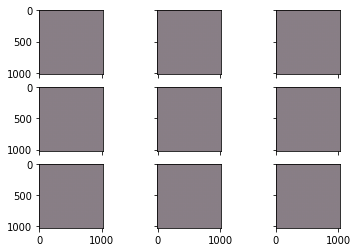

Iteration 6 of 30 - Fri Feb 24 20:12:57 2023
1/1 [==============================] - 621s 621s/step
Training discriminator ... - Fri Feb 24 20:23:25 2023
Training generator ... - Fri Feb 24 20:24:09 2023
1/1 [==============================] - 20s 20s/step
Epoch time 6 - Fri Feb 24 20:26:14 2023
Iteration 7 of 30 - Fri Feb 24 20:26:14 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:26:33 2023
Training generator ... - Fri Feb 24 20:27:11 2023
1/1 [==============================] - 18s 18s/step
Epoch time 7 - Fri Feb 24 20:29:04 2023
8 [D loss: 0.000000, acc.:100.00%] [G loss: 0.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

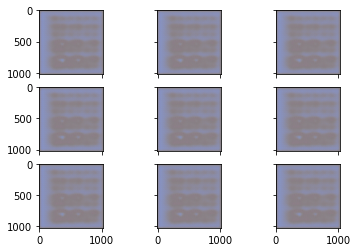

Iteration 8 of 30 - Fri Feb 24 20:29:12 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:29:31 2023
Training generator ... - Fri Feb 24 20:30:17 2023
1/1 [==============================] - 22s 22s/step
Epoch time 8 - Fri Feb 24 20:32:32 2023
Iteration 9 of 30 - Fri Feb 24 20:32:32 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 20:32:52 2023
Training generator ... - Fri Feb 24 20:33:30 2023
1/1 [==============================] - 18s 18s/step
Epoch time 9 - Fri Feb 24 20:35:41 2023
10 [D loss: 0.000000, acc.:100.00%] [G loss: 393227520.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

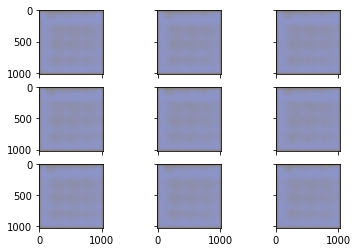

Iteration 10 of 30 - Fri Feb 24 20:35:49 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:36:08 2023
Training generator ... - Fri Feb 24 20:36:46 2023
1/1 [==============================] - 18s 18s/step
Epoch time 10 - Fri Feb 24 20:39:14 2023
Iteration 11 of 30 - Fri Feb 24 20:39:14 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 20:39:34 2023
Training generator ... - Fri Feb 24 20:40:12 2023
1/1 [==============================] - 18s 18s/step
Epoch time 11 - Fri Feb 24 20:42:13 2023
12 [D loss: 17934384.000000, acc.:56.25%] [G loss: 124726544.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

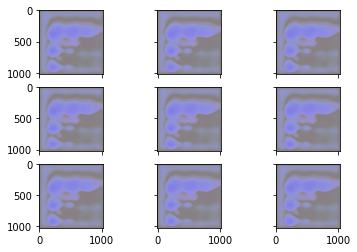

Iteration 12 of 30 - Fri Feb 24 20:42:21 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:42:40 2023
Training generator ... - Fri Feb 24 20:43:20 2023
1/1 [==============================] - 18s 18s/step
Epoch time 12 - Fri Feb 24 20:45:25 2023
Iteration 13 of 30 - Fri Feb 24 20:45:25 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:45:44 2023
Training generator ... - Fri Feb 24 20:46:23 2023
1/1 [==============================] - 19s 19s/step
Epoch time 13 - Fri Feb 24 20:48:25 2023
14 [D loss: 42885320.000000, acc.:32.81%] [G loss: 9163592.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

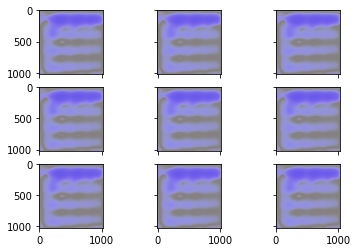

Iteration 14 of 30 - Fri Feb 24 20:48:33 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:48:52 2023
Training generator ... - Fri Feb 24 20:49:35 2023
1/1 [==============================] - 19s 19s/step
Epoch time 14 - Fri Feb 24 20:51:33 2023
Iteration 15 of 30 - Fri Feb 24 20:51:33 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:51:52 2023
Training generator ... - Fri Feb 24 20:52:31 2023
1/1 [==============================] - 18s 18s/step
Epoch time 15 - Fri Feb 24 20:54:30 2023
16 [D loss: 51167019.500000, acc.:12.50%] [G loss: 2844356.750000]
1/1 [==============================] - 6s 6s/step


<Figure size 216x216 with 0 Axes>

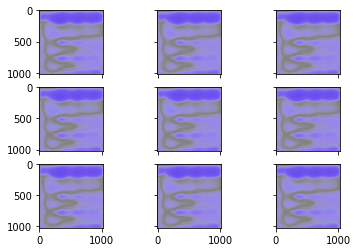

Iteration 16 of 30 - Fri Feb 24 20:54:39 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 20:54:58 2023
Training generator ... - Fri Feb 24 20:55:36 2023
1/1 [==============================] - 19s 19s/step
Epoch time 16 - Fri Feb 24 20:57:31 2023
Iteration 17 of 30 - Fri Feb 24 20:57:31 2023
1/1 [==============================] - 19s 19s/step
Training discriminator ... - Fri Feb 24 20:57:50 2023
Training generator ... - Fri Feb 24 20:58:28 2023
1/1 [==============================] - 18s 18s/step
Epoch time 17 - Fri Feb 24 21:00:21 2023
18 [D loss: 231012.640625, acc.:95.31%] [G loss: 1226403.625000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

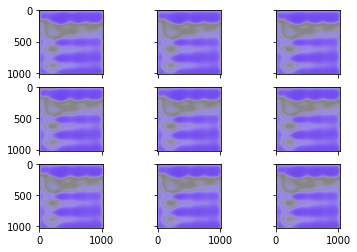

Iteration 18 of 30 - Fri Feb 24 21:00:29 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:00:48 2023
Training generator ... - Fri Feb 24 21:01:26 2023
1/1 [==============================] - 18s 18s/step
Epoch time 18 - Fri Feb 24 21:03:22 2023
Iteration 19 of 30 - Fri Feb 24 21:03:22 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:03:41 2023
Training generator ... - Fri Feb 24 21:04:19 2023
1/1 [==============================] - 19s 19s/step
Epoch time 19 - Fri Feb 24 21:06:10 2023
20 [D loss: 0.000000, acc.:100.00%] [G loss: 0.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

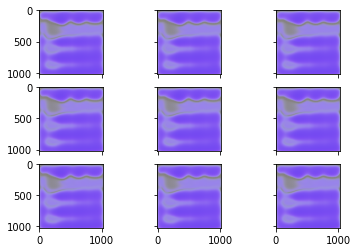

Iteration 20 of 30 - Fri Feb 24 21:06:18 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:06:37 2023
Training generator ... - Fri Feb 24 21:07:15 2023
1/1 [==============================] - 18s 18s/step
Epoch time 20 - Fri Feb 24 21:09:07 2023
Iteration 21 of 30 - Fri Feb 24 21:09:07 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:09:25 2023
Training generator ... - Fri Feb 24 21:10:03 2023
1/1 [==============================] - 18s 18s/step
Epoch time 21 - Fri Feb 24 21:12:00 2023
22 [D loss: 12643064.000000, acc.:76.56%] [G loss: 179773712.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

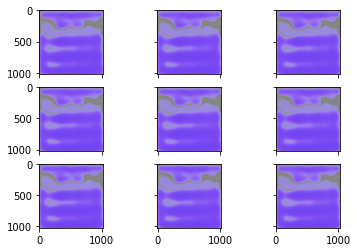

Iteration 22 of 30 - Fri Feb 24 21:12:11 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:12:30 2023
Training generator ... - Fri Feb 24 21:13:08 2023
1/1 [==============================] - 18s 18s/step
Epoch time 22 - Fri Feb 24 21:15:06 2023
Iteration 23 of 30 - Fri Feb 24 21:15:06 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:15:25 2023
Training generator ... - Fri Feb 24 21:16:03 2023
1/1 [==============================] - 18s 18s/step
Epoch time 23 - Fri Feb 24 21:18:18 2023
24 [D loss: 143979264.000000, acc.:73.44%] [G loss: 55097384.000000]
1/1 [==============================] - 6s 6s/step


<Figure size 216x216 with 0 Axes>

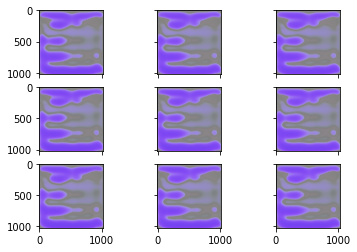

Iteration 24 of 30 - Fri Feb 24 21:18:27 2023
1/1 [==============================] - 20s 20s/step
Training discriminator ... - Fri Feb 24 21:18:48 2023
Training generator ... - Fri Feb 24 21:19:32 2023
1/1 [==============================] - 19s 19s/step
Epoch time 24 - Fri Feb 24 21:21:35 2023
Iteration 25 of 30 - Fri Feb 24 21:21:35 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:21:54 2023
Training generator ... - Fri Feb 24 21:22:32 2023
1/1 [==============================] - 18s 18s/step
Epoch time 25 - Fri Feb 24 21:24:33 2023
26 [D loss: 0.000000, acc.:100.00%] [G loss: 114615120.000000]
1/1 [==============================] - 6s 6s/step


<Figure size 216x216 with 0 Axes>

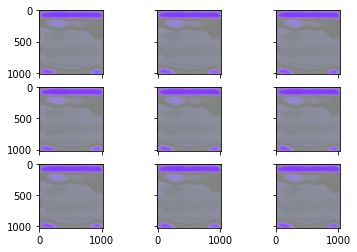

Iteration 26 of 30 - Fri Feb 24 21:24:42 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:25:01 2023
Training generator ... - Fri Feb 24 21:25:39 2023
1/1 [==============================] - 18s 18s/step
Epoch time 26 - Fri Feb 24 21:27:33 2023
Iteration 27 of 30 - Fri Feb 24 21:27:33 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:27:51 2023
Training generator ... - Fri Feb 24 21:28:30 2023
1/1 [==============================] - 18s 18s/step
Epoch time 27 - Fri Feb 24 21:30:21 2023
28 [D loss: 29628276.000000, acc.:92.19%] [G loss: 0.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

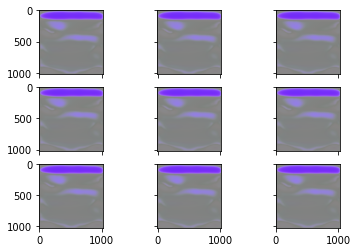

Iteration 28 of 30 - Fri Feb 24 21:30:29 2023
1/1 [==============================] - 18s 18s/step
Training discriminator ... - Fri Feb 24 21:30:48 2023
Training generator ... - Fri Feb 24 21:31:27 2023
1/1 [==============================] - 18s 18s/step
Epoch time 28 - Fri Feb 24 21:33:33 2023
Iteration 29 of 30 - Fri Feb 24 21:33:33 2023
1/1 [==============================] - 46s 46s/step
Training discriminator ... - Fri Feb 24 21:34:19 2023
Training generator ... - Fri Feb 24 21:35:03 2023
1/1 [==============================] - 20s 20s/step
Epoch time 29 - Fri Feb 24 21:37:05 2023
30 [D loss: 33840640.000000, acc.:78.12%] [G loss: 205106672.000000]
1/1 [==============================] - 5s 5s/step


<Figure size 216x216 with 0 Axes>

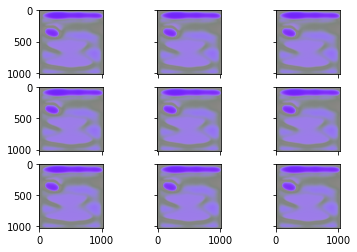

In [110]:
train_gan(iterations, batch_size, sample_interval)